## 1. Setup and Imports

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add src directory to path
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

# Import custom modules
from signal_processing import RadarSimulator, normalize_heatmap
from visualization import (
    plot_range_profile, plot_doppler_profile,
    plot_range_doppler_heatmap, plot_multiple_scenarios
)

# Set visualization parameters
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("✓ All imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Working directory: {os.getcwd()}")

✓ All imports successful!
NumPy version: 2.2.6
Working directory: D:\Guruji air assignment\notebooks


## 2. Initialize Radar Simulator

We'll create a radar simulator with realistic FMCW (Frequency Modulated Continuous Wave) parameters commonly used in mmWave automotive radar systems.

**Parameters:**
- Center Frequency: 77 GHz (automotive radar band)
- Bandwidth: 4 GHz
- Chirp Duration: 100 μs
- Number of Chirps: 128
- Samples per Chirp: 256

In [2]:
# Initialize radar simulator with realistic parameters
radar = RadarSimulator(
    fc=77e9,           # 77 GHz center frequency
    bandwidth=4e9,     # 4 GHz bandwidth
    sweep_time=100e-6, # 100 microseconds chirp duration
    num_chirps=128,    # 128 chirps per frame
    num_samples=256    # 256 ADC samples per chirp
)

# Display radar parameters
print("="*60)
print("RADAR SYSTEM PARAMETERS")
print("="*60)
print(f"Center Frequency:      {radar.fc/1e9:.1f} GHz")
print(f"Bandwidth:             {radar.bandwidth/1e9:.1f} GHz")
print(f"Chirp Duration:        {radar.sweep_time*1e6:.1f} μs")
print(f"Number of Chirps:      {radar.num_chirps}")
print(f"Samples per Chirp:     {radar.num_samples}")
print(f"\n{'DERIVED PARAMETERS':-^60}")
print(f"Range Resolution:      {radar.range_resolution:.3f} m")
print(f"Maximum Range:         {radar.max_range:.2f} m")
print(f"Doppler Resolution:    {radar.doppler_resolution:.3f} m/s")
print(f"Maximum Velocity:      {radar.max_velocity:.2f} m/s")
print("="*60)

RADAR SYSTEM PARAMETERS
Center Frequency:      77.0 GHz
Bandwidth:             4.0 GHz
Chirp Duration:        100.0 μs
Number of Chirps:      128
Samples per Chirp:     256

---------------------DERIVED PARAMETERS---------------------
Range Resolution:      0.037 m
Maximum Range:         9.60 m
Doppler Resolution:    0.152 m/s
Maximum Velocity:      1246.75 m/s


## 3. 1D Signal Generation & Analysis

### Scenario 1: Empty Room (Noise Only)

Generating empty room scenario...


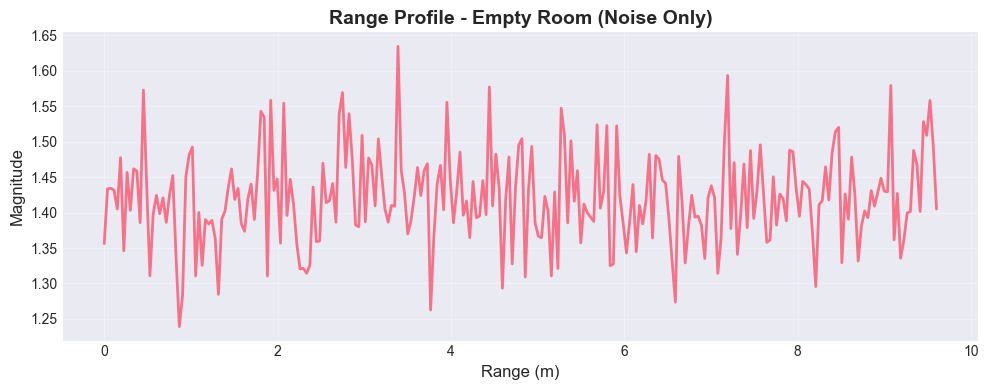

✓ Empty room signal shape: (128, 256)
  Mean power: 0.010038


In [3]:
# Generate empty room signal
print("Generating empty room scenario...")
signal_empty = radar.generate_empty_room(noise_power=0.01)

# Extract 1D range profile
range_profile_empty = radar.get_range_profile(signal_empty)

# Visualize
plot_range_profile(
    range_profile_empty,
    max_range=radar.max_range,
    title="Range Profile - Empty Room (Noise Only)",
    save_path='../outputs/figures/01_range_profile_empty.png'
)

print(f"✓ Empty room signal shape: {signal_empty.shape}")
print(f"  Mean power: {np.mean(np.abs(signal_empty)**2):.6f}")

### Scenario 2: Single Metal Object

Generating metal object scenario...


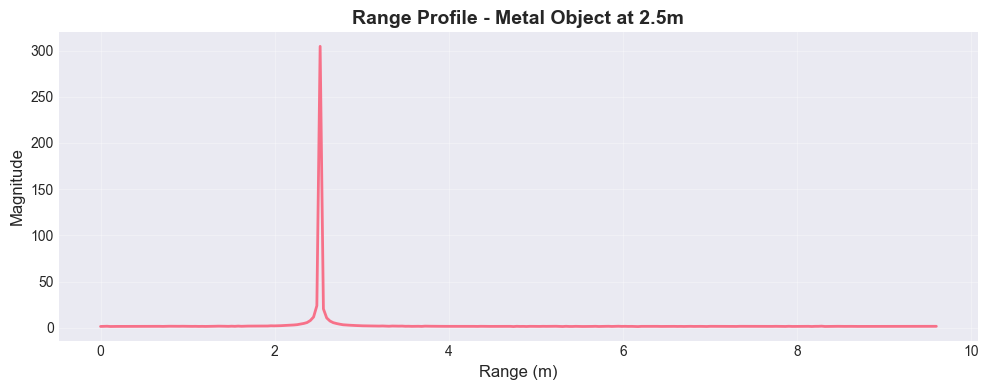

✓ Metal object signal shape: (128, 256)
  Detected peak at range: 2.51 m (expected 2.5 m)


In [4]:
# Generate metal object signal
print("Generating metal object scenario...")
signal_metal = radar.generate_metal_object(
    range_m=2.5,      # Object at 2.5 meters
    velocity=0.8,     # Moving at 0.8 m/s
    rcs=1.2,          # Strong radar cross-section
    noise_power=0.01
)

# Extract 1D range profile
range_profile_metal = radar.get_range_profile(signal_metal)

# Visualize
plot_range_profile(
    range_profile_metal,
    max_range=radar.max_range,
    title="Range Profile - Metal Object at 2.5m",
    save_path='../outputs/figures/02_range_profile_metal.png'
)

# Find peak location
peak_idx = np.argmax(range_profile_metal)
detected_range = (peak_idx / len(range_profile_metal)) * radar.max_range
print(f"✓ Metal object signal shape: {signal_metal.shape}")
print(f"  Detected peak at range: {detected_range:.2f} m (expected 2.5 m)")

### Doppler Profile Analysis

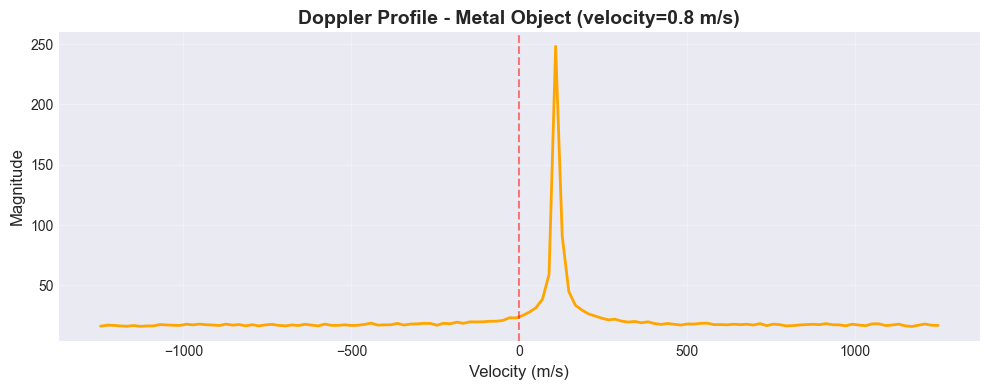

✓ Doppler analysis complete


In [5]:
# Extract Doppler profiles
doppler_profile_empty = radar.get_doppler_profile(signal_empty)
doppler_profile_metal = radar.get_doppler_profile(signal_metal)

# Plot Doppler profile for metal object
plot_doppler_profile(
    doppler_profile_metal,
    max_velocity=radar.max_velocity,
    title="Doppler Profile - Metal Object (velocity=0.8 m/s)",
    save_path='../outputs/figures/03_doppler_profile_metal.png'
)

print("✓ Doppler analysis complete")

## 4. 2D Range-Doppler Map Generation

Now we'll generate 2D range-Doppler heatmaps using 2D FFT processing.

In [6]:
# Generate Range-Doppler maps for all scenarios
print("Generating 2D Range-Doppler maps...")

# Empty room
rd_map_empty = radar.generate_range_doppler_map(signal_empty)

# Metal object
rd_map_metal = radar.generate_range_doppler_map(signal_metal)

# Clutter scenario
print("Generating clutter scenario...")
signal_clutter = radar.generate_clutter_scenario(num_targets=5, noise_power=0.02)
rd_map_clutter = radar.generate_range_doppler_map(signal_clutter)

print(f"✓ Range-Doppler map shape: {rd_map_metal.shape}")
print(f"  Doppler bins: {rd_map_metal.shape[0]}, Range bins: {rd_map_metal.shape[1]}")

Generating 2D Range-Doppler maps...
Generating clutter scenario...
✓ Range-Doppler map shape: (128, 256)
  Doppler bins: 128, Range bins: 256


### Visualize Range-Doppler Heatmaps

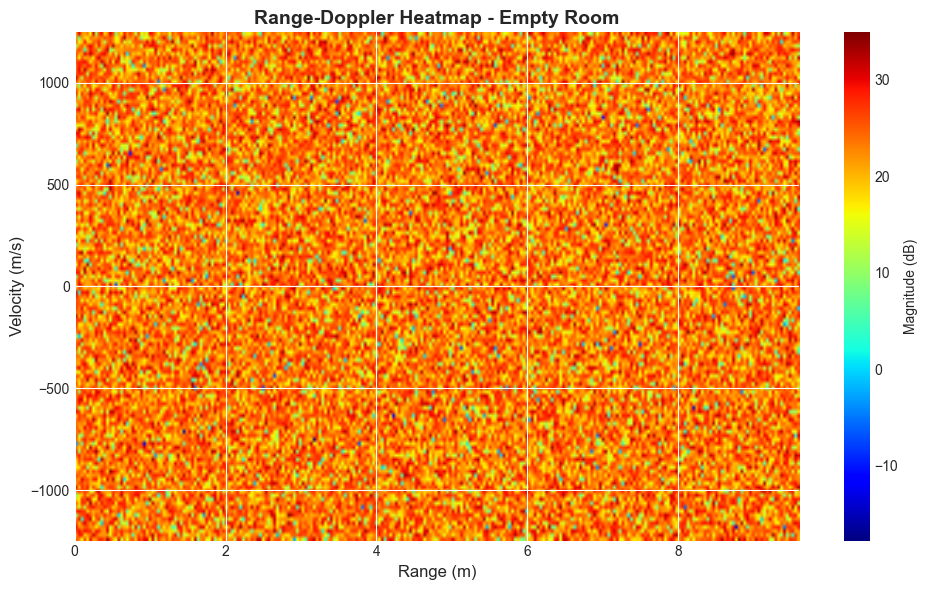

In [7]:
# Plot empty room
plot_range_doppler_heatmap(
    rd_map_empty,
    max_range=radar.max_range,
    max_velocity=radar.max_velocity,
    title="Range-Doppler Heatmap - Empty Room",
    save_path='../outputs/figures/04_heatmap_empty.png'
)

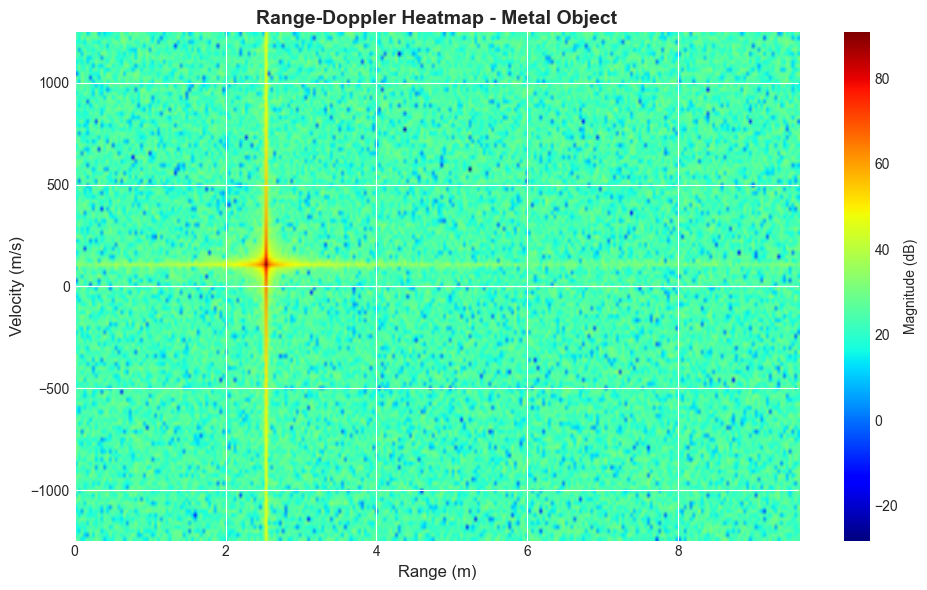

In [8]:
# Plot metal object
plot_range_doppler_heatmap(
    rd_map_metal,
    max_range=radar.max_range,
    max_velocity=radar.max_velocity,
    title="Range-Doppler Heatmap - Metal Object",
    save_path='../outputs/figures/05_heatmap_metal.png'
)

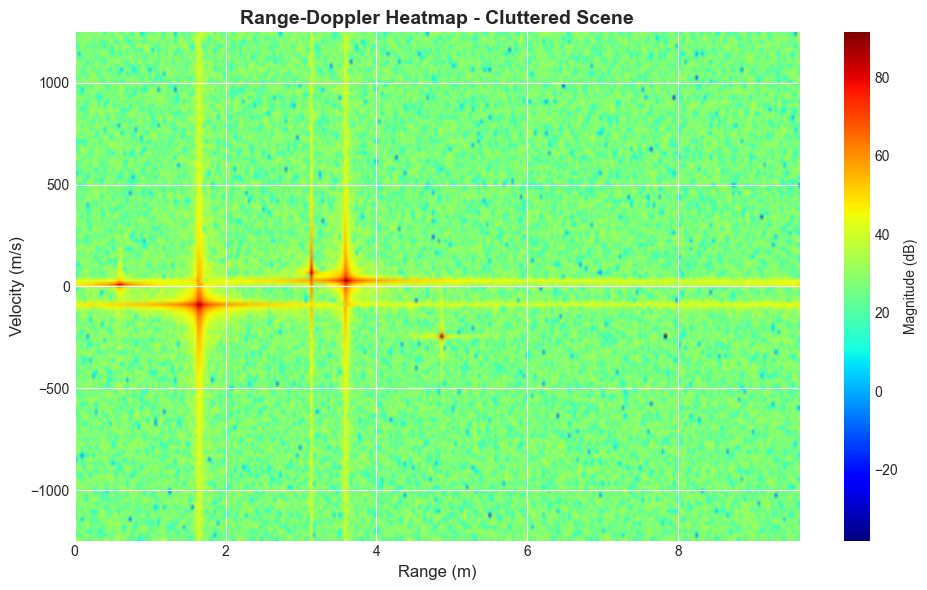

In [9]:
# Plot clutter scenario
plot_range_doppler_heatmap(
    rd_map_clutter,
    max_range=radar.max_range,
    max_velocity=radar.max_velocity,
    title="Range-Doppler Heatmap - Cluttered Scene",
    save_path='../outputs/figures/06_heatmap_clutter.png'
)

## 5. Multiple Scenarios Comparison

Let's compare all three scenarios side by side.

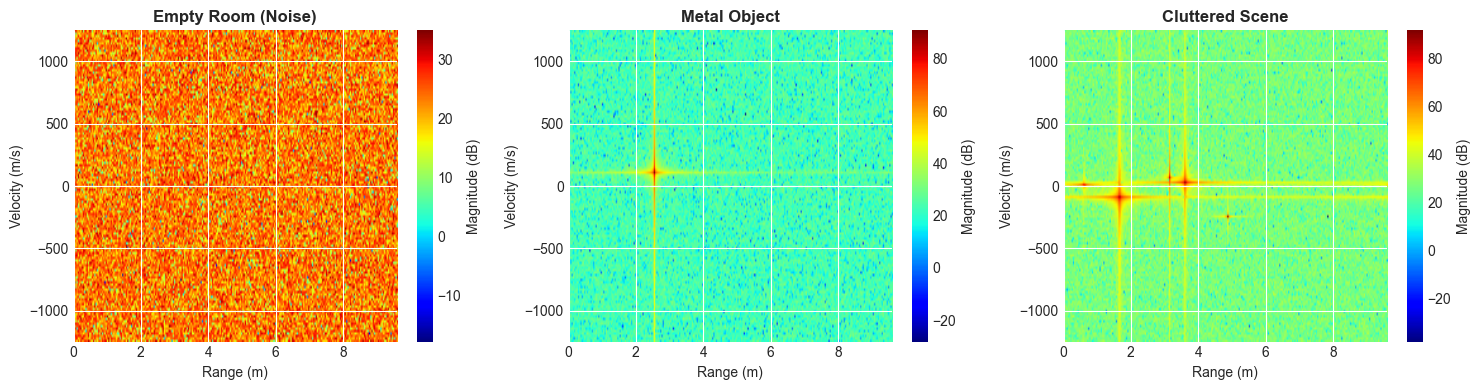

✓ Scenario comparison complete


In [10]:
# Create comparison plot
scenarios = [
    (rd_map_empty, "Empty Room (Noise)"),
    (rd_map_metal, "Metal Object"),
    (rd_map_clutter, "Cluttered Scene")
]

plot_multiple_scenarios(
    scenarios,
    max_range=radar.max_range,
    max_velocity=radar.max_velocity,
    save_path='../outputs/figures/07_scenarios_comparison.png'
)

print("✓ Scenario comparison complete")

## 6. Advanced Signal Processing

### 6.1 Window Function Analysis

Testing window functions...


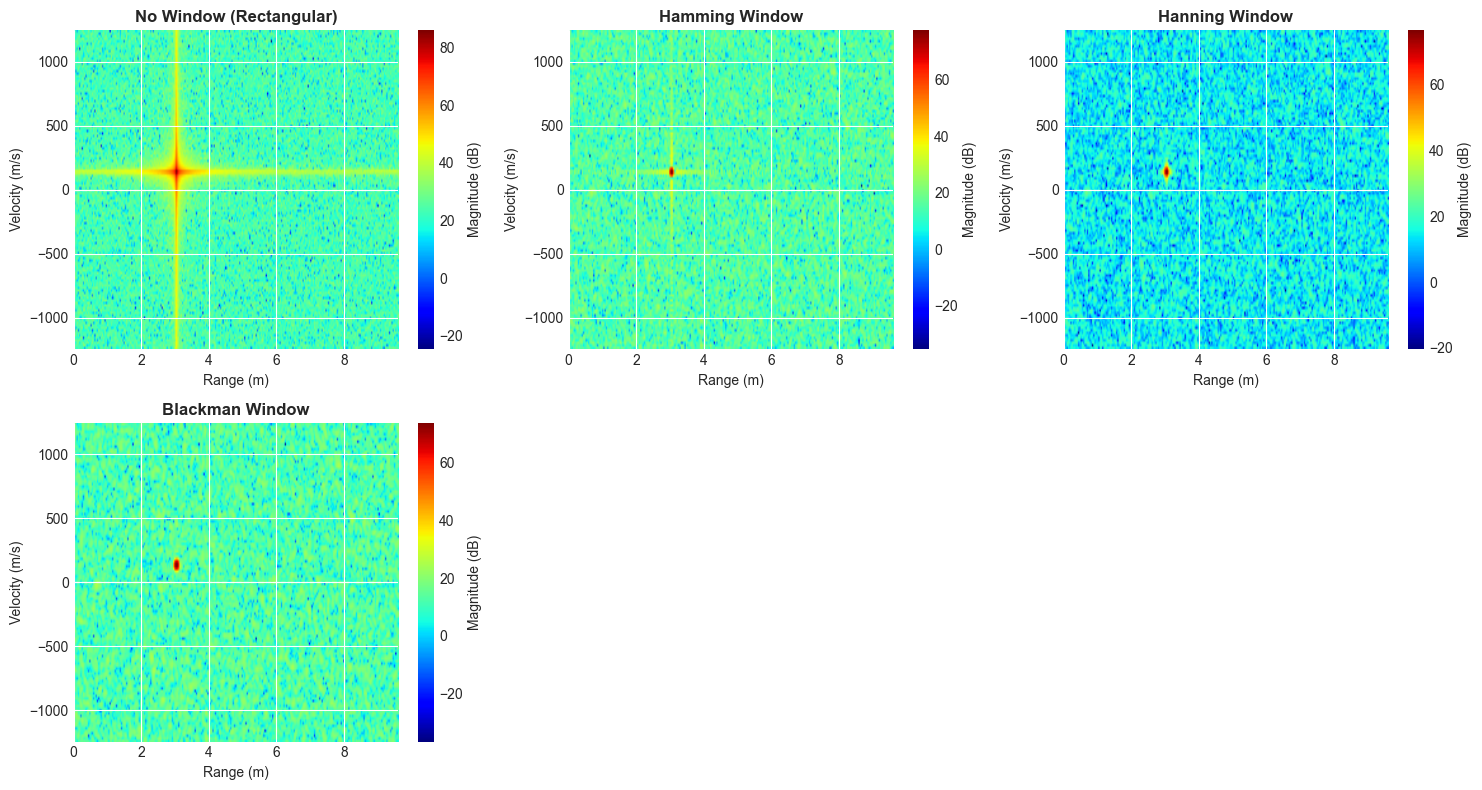

✓ Window function analysis complete


In [11]:
# Compare different window functions
print("Testing window functions...")

# Generate a metal target signal
signal_test = radar.generate_metal_object(range_m=3.0, velocity=1.0, rcs=1.0)

# Apply different windows
windows = ['hamming', 'hanning', 'blackman']
windowed_maps = []

for window_type in windows:
    signal_windowed = radar.apply_windowing(signal_test, window_type)
    rd_map = radar.generate_range_doppler_map(signal_windowed)
    windowed_maps.append((rd_map, f"{window_type.capitalize()} Window"))

# Add no window for comparison
rd_map_no_window = radar.generate_range_doppler_map(signal_test)
windowed_maps.insert(0, (rd_map_no_window, "No Window (Rectangular)"))

plot_multiple_scenarios(
    windowed_maps,
    max_range=radar.max_range,
    max_velocity=radar.max_velocity,
    save_path='../outputs/figures/08_window_comparison.png'
)

print("✓ Window function analysis complete")

### 6.2 Multiple Target Scenario

Generating multi-target scenario...


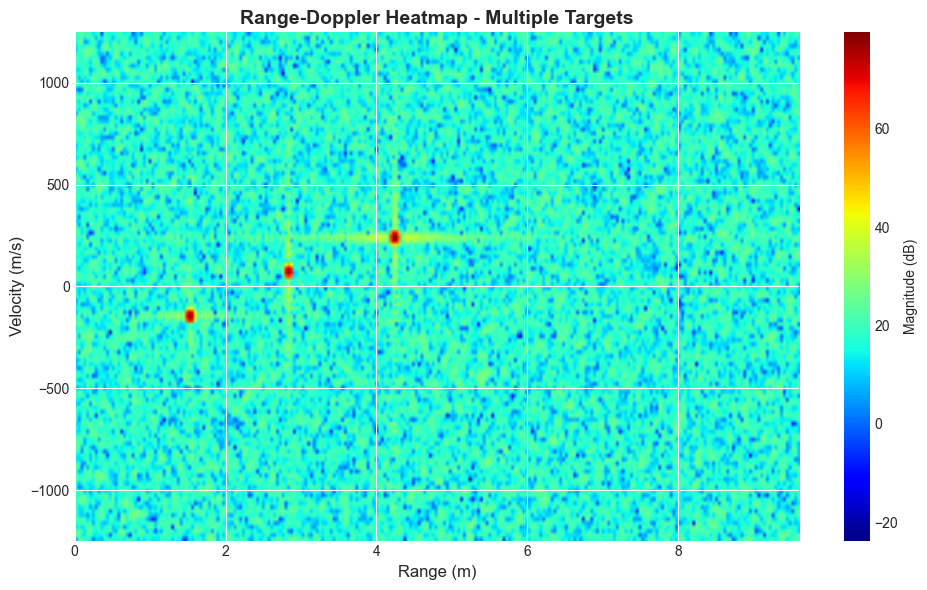

✓ Multi-target scenario generated
  Targets: 3
  Ranges: [1.5 2.8 4.2] m
  Velocities: [-1.2  0.5  1.8] m/s


In [12]:
# Create a complex multi-target scenario
print("Generating multi-target scenario...")

# Define multiple targets with different properties
ranges = np.array([1.5, 2.8, 4.2])
velocities = np.array([-1.2, 0.5, 1.8])
rcs_values = np.array([1.0, 0.8, 1.2])

signal_multi = radar.generate_target_signal(
    ranges=ranges,
    velocities=velocities,
    rcs=rcs_values,
    noise_power=0.015
)

# Apply windowing
signal_multi = radar.apply_windowing(signal_multi, 'hamming')

# Generate Range-Doppler map
rd_map_multi = radar.generate_range_doppler_map(signal_multi)

# Visualize
plot_range_doppler_heatmap(
    rd_map_multi,
    max_range=radar.max_range,
    max_velocity=radar.max_velocity,
    title="Range-Doppler Heatmap - Multiple Targets",
    save_path='../outputs/figures/09_heatmap_multitarget.png'
)

print(f"✓ Multi-target scenario generated")
print(f"  Targets: {len(ranges)}")
print(f"  Ranges: {ranges} m")
print(f"  Velocities: {velocities} m/s")

### 6.3 CFAR Detection (Constant False Alarm Rate)

Applying CFAR detection algorithm...


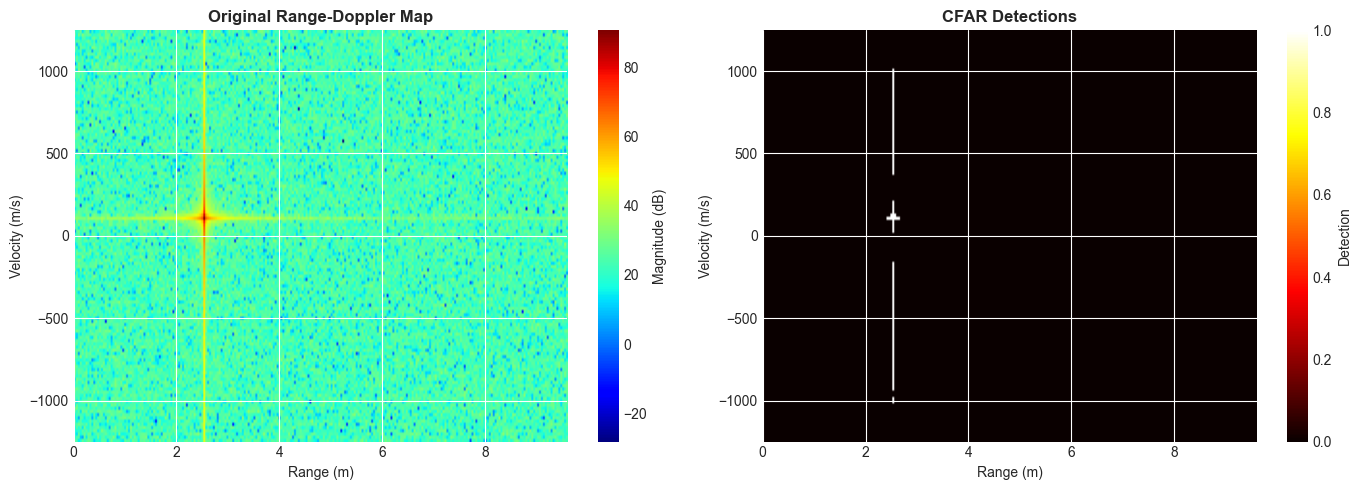

✓ CFAR detection complete
  Number of detections: 93


In [13]:
# Apply CFAR detection
print("Applying CFAR detection algorithm...")

detections = radar.cfar_detection(
    rd_map_metal,
    guard_cells=4,
    training_cells=8,
    pfa=1e-4  # Probability of false alarm
)

# Visualize CFAR results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Original heatmap
extent = [0, radar.max_range, -radar.max_velocity, radar.max_velocity]
data = 20 * np.log10(rd_map_metal + 1e-10)
im1 = ax1.imshow(data, aspect='auto', cmap='jet', extent=extent, origin='lower')
ax1.set_xlabel('Range (m)')
ax1.set_ylabel('Velocity (m/s)')
ax1.set_title('Original Range-Doppler Map', fontweight='bold')
plt.colorbar(im1, ax=ax1, label='Magnitude (dB)')

# CFAR detections
im2 = ax2.imshow(detections, aspect='auto', cmap='hot', extent=extent, origin='lower')
ax2.set_xlabel('Range (m)')
ax2.set_ylabel('Velocity (m/s)')
ax2.set_title('CFAR Detections', fontweight='bold')
plt.colorbar(im2, ax=ax2, label='Detection')

plt.tight_layout()
plt.savefig('../outputs/figures/10_cfar_detection.png', dpi=300, bbox_inches='tight')
plt.show()

num_detections = np.sum(detections > 0)
print(f"✓ CFAR detection complete")
print(f"  Number of detections: {num_detections}")

## 7. Summary and Results

### Key Achievements:
✓ Successfully generated synthetic 1D and 2D radar signals  
✓ Implemented FFT-based range and Doppler processing  
✓ Created multiple scenarios: empty room, metal objects, and clutter  
✓ Applied advanced techniques: windowing and CFAR detection  
✓ Generated comprehensive visualizations

### Generated Outputs:
All figures saved to `outputs/figures/`:
- Range profiles (empty, metal object)
- Doppler profiles
- Range-Doppler heatmaps (multiple scenarios)
- Window function comparison
- Multi-target detection
- CFAR detection results

## 8. Save Sample Data for Next Phases

In [14]:
# Save sample signals for use in next notebooks
print("Saving sample data...")

# Create output directory if it doesn't exist
os.makedirs('../data/raw', exist_ok=True)

# Save signals
np.savez_compressed(
    '../data/raw/sample_signals.npz',
    signal_empty=signal_empty,
    signal_metal=signal_metal,
    signal_clutter=signal_clutter,
    signal_multi=signal_multi,
    rd_map_empty=rd_map_empty,
    rd_map_metal=rd_map_metal,
    rd_map_clutter=rd_map_clutter,
    rd_map_multi=rd_map_multi
)

print("✓ Sample data saved to 'data/raw/sample_signals.npz'")
print("\n" + "="*60)
print("PART 1 COMPLETE!")
print("="*60)
print("Proceed to Part 2: Classification Model Training")

Saving sample data...
✓ Sample data saved to 'data/raw/sample_signals.npz'

PART 1 COMPLETE!
Proceed to Part 2: Classification Model Training
